# Mobile Game A/B Testing

## Background

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It’s a classic “connect three”-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We’re not kidding! Check out this short demo:

https://youtu.be/GaP5f0jVTWE

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player’s enjoyment of the game being increased and prolonged.

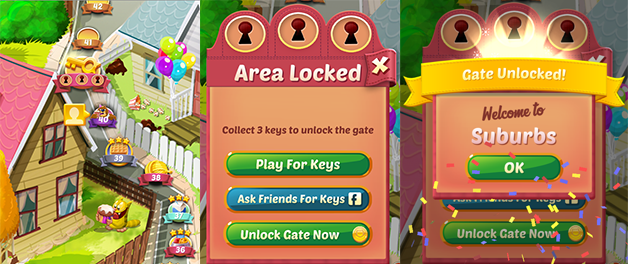

But where should the gates be placed? This analysis will be on how gate placement affects the retention rate of players. Initially the first gate was placed at level 30, i'll be condicting an AB-test on what happens if that gate were moved to level 40.



## Data and Library Imports 

In [19]:
import pandas as pd
%matplotlib inline

In [1]:
# Create a dataframe 
df = pd.read_csv("cookie_cats.csv")

In [2]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Data keys & info. Check for missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


* Data consist of 90188 entries with no null values.
* version: random app version placement upon installation of player into the control group where player encounters a gate at level 30 or treatment group where the player encounters a gate at level 40.
* sum_grounds: number of rounds player by the individual within the first 14 days on installing the game.
* retention_1: whether the player came back after playing for 1 day after installation.
* retention_7: whether the player came back after playing for 7 days after installation. 


In [17]:
# Count of the numbers of players in each group
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

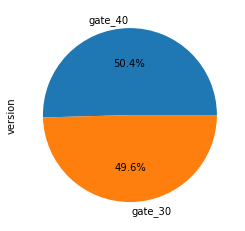

In [18]:
df.version.value_counts().plot.pie(label='version', autopct='%1.1f%%')

* Both groups relatively have an equal distribution of players.

## Player Behavior 

In [20]:
# Display general descriptve stats
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [26]:
# Find outliers
no_outlier_df = df['sum_gamerounds'] > 49850

In [30]:
# Find outliers
no_outlier_df.value_counts()

False    90188
True         1
Name: sum_gamerounds, dtype: int64

In [31]:
# Find outliers
df.iloc[no_outlier_df.values]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [32]:
# Drop outliers
df.drop(index=[57702], inplace = True)

In [33]:
# Distributions without outlier
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

## Distribution of Game Rounds

Text(0, 0.5, 'Number of Players')

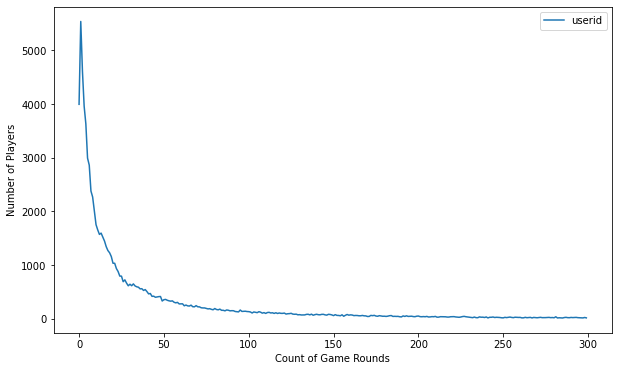

In [44]:
# Distribution of players that played 300 rounds
distribution_df = df.groupby(['sum_gamerounds']).agg({'userid':'count'}).reset_index()

ax = distribution_df.head(300).plot(figsize=(10,6), x='sum_gamerounds', y='userid')
ax.set_xlabel("Count of Game Rounds")
ax.set_ylabel("Number of Players")

* The distribution is skewed with a long tail that starts looking the same after 300 rounds.
* A large number of players only played up to about 25 rounds. 
* Some players install the game but dont even play a single round. 

## 1 Day Rentention Analysis (% of players that comes back to play the game a day after installation)

In [45]:
# Get retention rate of people who come back after 1 day
df['retention_1'].sum() / df['retention_1'].count()

0.4452144409455803

* A little less than 50% of users come back after playing for one day

In [47]:
# Get retention rate of people who come back based on the 2 groups
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

* The retention rate dropped slightly from 44.8% to 44.2% upon moving the gate to level 40. 
* A .06% change may seem small but when it comes to retention, it may prove to be a large impact.

While theres certainly a difference in the data, how certain should one be that having a gate at level 40 will be worse in the future?

## Test confidence in the difference 

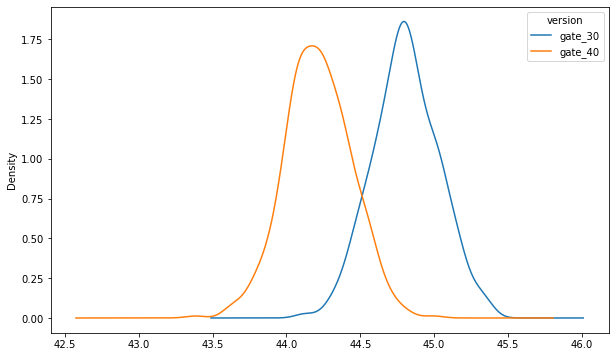

In [49]:
# Use boostrapping to repeatedly re-sample dataset with replacements and calculate 1 day retention for those samples
# Create a list of possible means for each group
boot_1d = []
for i in range(500):
    boot_mean = 100*df.sample(replace=True, frac=1).groupby(['version'])['retention_1'].mean()
    boot_1d.append(boot_mean)

# Transform the list into a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# Create a Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(figsize=(10,6), kind='kde');

The two distributions represent the bootstrap uncertainty over what the underlying 1 day retention could be for the two groups. There seems to be evidence of some sort of difference.

Text(0.5, 0, '% difference in means')

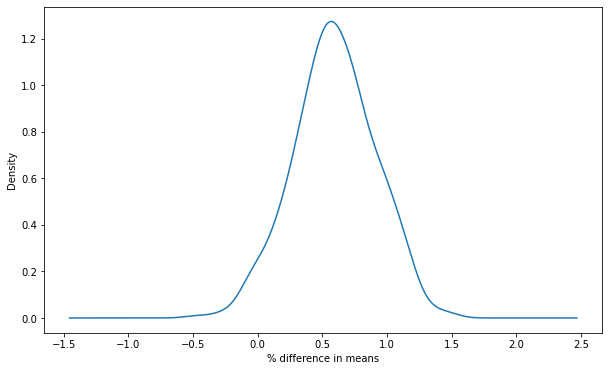

In [50]:
# Adding a column with the % difference between the two groups
boot_1d['difference'] = boot_1d.gate_30 - boot_1d.gate_40

# Ploting the bootstrap % difference
ax = boot_1d['difference'].plot(figsize=(10,6),kind='kde')
ax.set_xlabel("% difference in means")

* Most likely the difference in percentage is around 1-2%.
* Most of the distribution is above 0%.

## Probability of the difference

In [53]:
# Calulcate probability that 1 day retention is greater when the gate is at level 30
prob = 1.0*(boot_1d['difference'] > 0).sum()/len(boot_1d)

# Print probability 
print('{:.2%}'.format(prob))

96.00%


## 7 Day Rentention Analysis (% of players that comes back to play the game seven days after installation)

In [55]:
# Calculating 7 day retention for both groups
df.groupby(['version'])['retention_7'].mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

* Retention rate is slightly lower when the gate is at level 40. From 19% to 18.2%.


## Test confidence in the difference 


100.0%


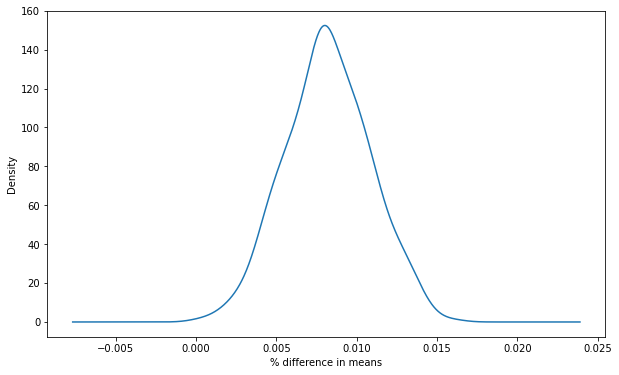

In [57]:
# Create a list with bootstrapped means for each group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(['version'])['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transform the list into a DataFrame
boot_7d = pd.DataFrame(boot_7d)
# Adding a column with the % difference between the two AB-groups
boot_7d['difference'] = boot_7d.gate_30 - boot_7d.gate_40

# Plot the bootstrap % difference
ax = boot_7d['difference'].plot(figsize=(10,6), kind='kde')
ax.set_xlabel("% difference in means")


## Probability of the difference

In [58]:
# Calculating the probability that 7 day retention is greater when the gate is at level 30
prob = (boot_7d['difference'] > 0).sum()/len(boot_7d)

# Probability
print('{:.1%}'.format(prob))

100.0%


## Conclusion

The results from the bootstrap test imply that there is strong evidence that retention for 7 days is higher when the gate is placed at level 30 rather than at lvl 40, as well as within the 1 day retention test as well. The gate should be kept at level 30 even if the % change may seem small, a change is still a change especially when it comes to retention metrics as keeping a player base is one of the most important aspects to keeping a game alive. 